# Эконометрика

## Домашняя работа №1. GARCH модель.
## Студент: Евгений Станкевич, МФИН-161

In [1]:
# coding=utf-8
import numpy as np
from math import sqrt

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 120

import matplotlib.pyplot as plt
from numpy.core.multiarray import zeros
from numpy.matlib import randn

## Задание 1.

Смоделировать в программе GARCH (1,1) - процесс длиной в 1000 наблюдений. Параметры процесса можно задать самостоятельно.

### Решение

Общий вид GARCH(p,q)-процесса:

$$y_t  = C + \epsilon_t$$

$$\epsilon_t=\sigma_t e_t, e_t  \sim  N(0,1)$$

$$\sigma^2_t= \omega + \sum_{i=1}^{p} \delta_{i} \epsilon_{t-i}^2 + \sum_{j=1}^{q} \gamma_{j} \sigma_{t-j}^2$$

Реализуем функцию генерации GARCH(1,1)-процесса:

In [2]:
def garch11(n, c, omega, delta, gamma, burn=500):
    sigmas = zeros(n + burn)
    epsilons = zeros(n + burn)
    es = randn(n + burn)
    y = zeros(n + burn)
    for t in range(1, n + burn):
        sigmas[t] = omega + delta * np.square(epsilons[t-1]) + gamma * sigmas[t - 1]
        epsilons[t] = sqrt(sigmas[t]) * es[0,t]
        y[t] = c + epsilons[t]
    return y[burn:]

Теперь сгенерируем и нарисуем наш GARCH(1,1)-процесс:

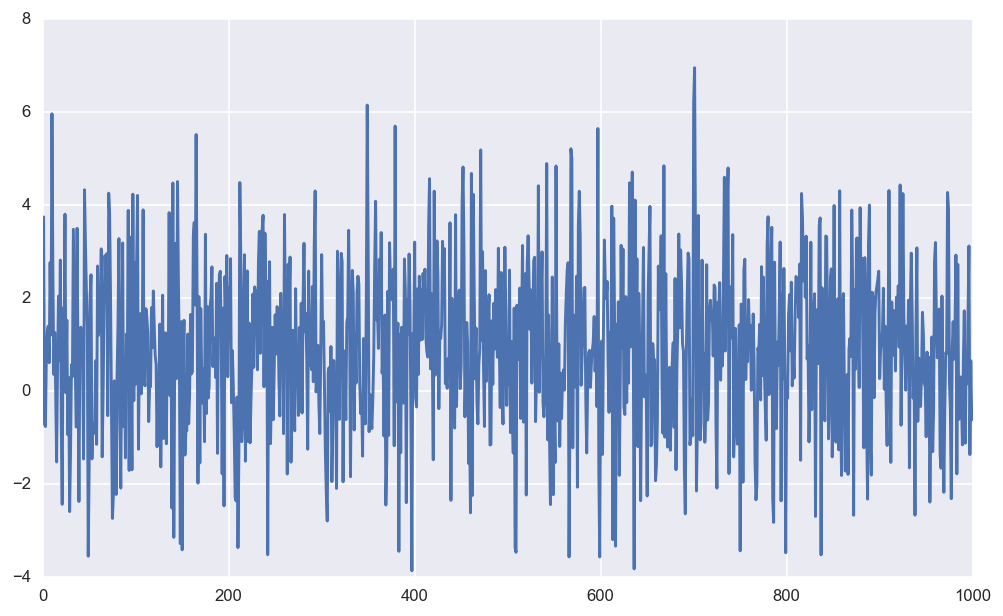

In [3]:
garch11_ts = garch11(1000, 1, 2, 0.1, 0.3)
p = plt.plot(garch11_ts)

Покажем первые 50 значений нашего ряда:

In [4]:
garch11_ts[:50]

array([ 2.56023583,  3.75033792, -0.71258534, -0.75554916,  0.83084842,
        1.28506146,  1.40384318,  0.61564039,  2.77001404,  1.21391274,
        5.96981041,  2.49936987,  0.36350405,  1.26697991, -0.01770701,
       -1.51867204,  0.5212504 ,  2.04715268,  0.65792166,  2.82291684,
       -0.70866061, -2.42997648,  1.79376826,  0.90152581,  3.80945784,
       -0.03263948,  1.52924903, -0.93302468,  0.29955454, -2.58579752,
       -1.23465581,  0.57546717,  0.31535324,  3.48569064,  2.03481751,
        0.59925804, -0.76745194,  3.50691084,  0.61083008, -2.36879903,
        0.85250862,  1.37992641,  1.14939625,  0.72359461, -1.45498771,
        4.33348761,  3.14381763,  2.18353816,  1.40720743, -3.54584103])

### Приведем решение без самописных велосипедов

Для моделирования будем использовать библиотеку [ARCH](https://pypi.python.org/pypi/arch).

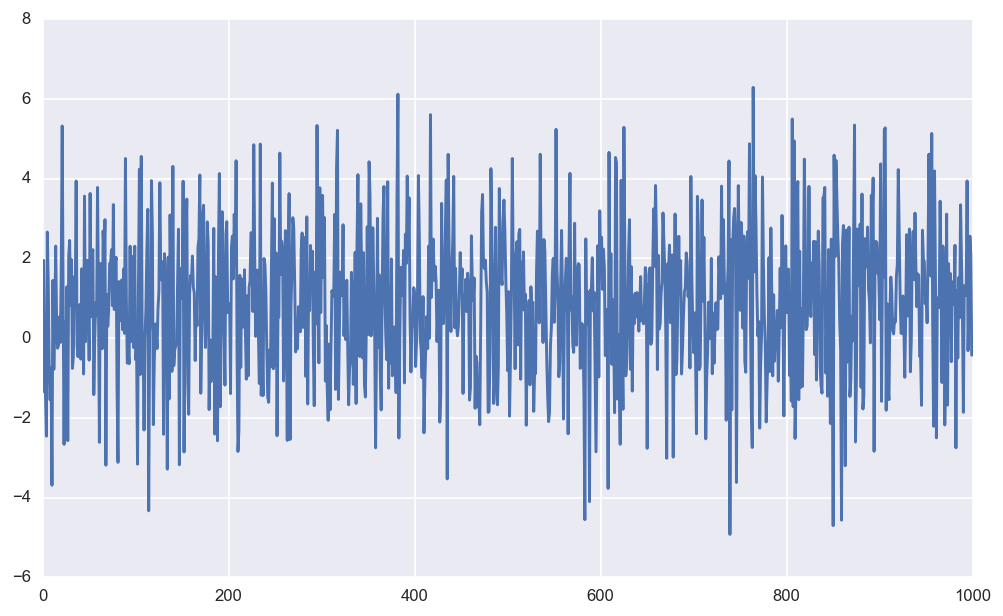

In [5]:
from arch.univariate import ConstantMean, GARCH

cm = ConstantMean()
cm.volatility = GARCH()
cm_params = np.array([1])
garch_params = np.array([2.0, 0.1, 0.3])
params = np.concatenate((cm_params, garch_params))
sim_data = cm.simulate(params, 1000)
garch11_ts_2 = sim_data['data']
p = plt.plot(garch11_ts_2)

Покажем первые 50 значений нашего ряда:

In [6]:
np.array(garch11_ts_2[:50])

array([-0.46116161,  1.95126118, -1.3512624 , -1.37129966, -2.45861404,
        2.66216017,  1.38348567, -0.76795067, -1.54691326, -0.7383294 ,
       -3.68948836,  1.44956633, -0.78300864,  0.27623673,  2.31140051,
        0.42326807, -0.25194402, -0.17968655,  0.53384515, -0.10676848,
        1.78188592,  5.32407818,  0.99396763, -2.66333096,  0.40725992,
       -1.57365541,  1.29021451, -2.5709255 ,  2.0459128 ,  2.45127356,
        0.8252249 ,  1.9693828 , -0.75600438, -0.4691915 ,  1.54277998,
        0.91603522,  3.94313731, -0.18772838, -0.46376295,  0.6429449 ,
        0.84607649, -0.52542096,  1.74127966,  1.01600893, -0.8990628 ,
        3.56484566, -0.08730531,  1.54814892,  1.9552844 ,  0.70945501])

## Задание №2

Мы имеем ряд Y_t, полученный выше. Пусть мы знаем, что это GARCH(1,1)-процесс, но при этом сделаем вид, как будто мы не знаем параметров этого ряда: c=?, $\omega$ = ?, $\delta$ = ?, $\gamma$ = ?.
И теперь нашей задачей будет оценить по методу максимального правдоподобия неизвестные параметры ряда.

### Решение

Запишем функцию плотности совместного распределения значений $Y_t$:

$$f_{Y_1,Y_2,...,Y_T} = \prod_{t=1}^{T} \frac{1}{\sqrt{2 \pi \sigma_{t}^{2}}} * \exp{ \left\{- \frac{\epsilon_{t}^{2}}{2 \sigma_{t}^{2}} \right\}}$$

,где $\sigma_{t}^{2} = \omega + \delta \epsilon_{t-1}^2 + \gamma \sigma_{t-1}^2$, $\epsilon_t = y_t - c$

Прологорифмировав, получаем следующую вункцию правдоподобия:

$$I(Y_1,Y_2,...,Y_T) = \sum_{t=1}^{T} \left( - \frac{1}{2} \ln(2\pi) - \frac{1}{2} \ln(\sigma_{t}^{2}) - \frac{\epsilon_{t}^{2}}{2 \sigma_{t}^{2}}\right)$$

$$I(Y_1,Y_2,...,Y_T) = \sum_{t=1}^{T} \left( - \frac{1}{2} \ln(2\pi) - \frac{1}{2} \ln(\sigma_{t}^{2}) - \frac{(Y_t - c)^{2}}{2 \sigma_{t}^{2}}\right)$$

Для нахождения оптимальных параметров процесса, при котором вероятность одновременно наблюдаемых $Y_t$ будет макимальна, необходимо решение задачи максимизации заданного функционала. Дополнительно мы должны наложить ограничение на параметры $\omega$, $\delta$ и $\gamma$, а именно: 

- $\delta + \gamma < 1$
- $\delta >= 0$
- $\gamma >= 0$
- $\omega > 0$

Для начала напишем функцию для вычисления значения функционала в точке $[c, \omega, \delta, \gamma]$ при заданных $Y_t$:

In [7]:
from math import log, pi

def func(x, y):
    c = x[0]
    omega = x[1]
    gamma = x[2]
    delta = x[3]
    sum = 0
    # за первое значение квадрата сигмы будем считать ее среднее
    sigma_sq_prev = omega
    for i in range(1, y.size):
        # по хорошему тут нужно без цикла обходится, очень медлено
        sigma_sq = omega + delta * sigma_sq_prev + gamma * np.square(y[i-1] - c)
        sigma_sq_prev = sigma_sq
        sum += -0.5 * log(2 * pi) - 0.5 * log(sigma_sq) - np.square(y[i] - c) / (2 * sigma_sq)
    return -sum # потому что будем искать максимум

Для максимизации функционала при условии заданных ограничений будем использовать [метод последовательного квадратичного программирования](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)

Подготовим ограничения:

In [8]:
constraints = (
    # - delta -  gamma + 1 >= 0
    {
        'type': 'ineq',
        'fun' : lambda x: np.array([- x[2] - x[3] + 1]),
        'jac' : lambda x: np.array([0.0, 0.0, -1.0, -1.0])
    },
    # omega >= 0.000001
    {
        'type': 'ineq',
        'fun' : lambda x: np.array([x[1] - 0.000001]),
        'jac' : lambda x: np.array([0.0, 1.0, 0.0, 0.0])
    },
    # gamma >= 0.001
    {
        'type': 'ineq',
        'fun' : lambda x: np.array([x[2] - 0.001]),
        'jac' : lambda x: np.array([0.0, 0.0, 1.0, 0.0])
    },
    # delta >= 0.001
    {
        'type': 'ineq',
        'fun' : lambda x: np.array([x[3] - 0.001]),
        'jac' : lambda x: np.array([0.0, 0.0, 0.0, 1.0])
    }
)

Осталось совсем немного, для процедуры оптимизации кто то должен считать градиент, напишем функцию, которая делает функцию оценки градиента для заданной функции:

In [9]:
from scipy.optimize.slsqp import approx_jacobian

def jac_factory(fun, epsilon):
    """
    Создает функцию для численной оценки якобиана заданной функци.

    :param fun: функция, для которой необходимо оценивать якобиан
    :param epsilon: шаг для численной оценки якобиана
    :return: функция оценки якобиана
    """
    def jac(x, *args):
        return approx_jacobian(x, fun, epsilon, *args)
    return jac

Зададим некоторое начальное решение и запустим процедуру оптимизации:

In [10]:
from scipy.optimize import minimize
from scipy.optimize.slsqp import _epsilon

x = np.array([0.9, 2.5, 0.2, 0.5])

result = minimize(
        func, x, args=(garch11_ts,), jac=jac_factory(func, _epsilon),
        constraints=constraints, method='SLSQP', options={'disp': True}
)

print(result.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2002.87337899
            Iterations: 16
            Function evaluations: 25
            Gradient evaluations: 16
[ 0.90787388  2.08960955  0.08445914  0.27255011]


Мы получили близкие к истинным значения параметров процесса. Посмотрим как можно было просто оценить модель с помощью той же библиотеки ARCH:

In [11]:
from arch import arch_model

am = arch_model(garch11_ts)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 2004.7125060092367
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2004.70280854
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -2004.70
Distribution:                  Normal   AIC:                           4017.41
Method:            Maximum Likelihood   BIC:                           4037.04
                                        No. Observations:                 1000
Date:                Thu, Dec 08 2016   Df Residuals:                      996
Time:                        02:18:45   Df Model:                            4
            